In [1]:
import pdfplumber # Go to https://github.com/jsvine/pdfplumber for installation instructions and explanation
import numpy
import pandas
import os

In [2]:
file_dir = r'floorplan.pdf' # Change to the location of the pdf file in your directory
full = pdfplumber.open(file_dir).pages[0]

In [3]:
print(len(full.curves))
print(len(full.lines))
full.curves[0]

70197
24805


{'bottom': Decimal('1530.520'),
 'doctop': Decimal('1527.280'),
 'evenodd': False,
 'fill': False,
 'height': Decimal('3.240'),
 'linewidth': Decimal('2'),
 'non_stroking_color': (0.30196079612, 0.30196079612, 0.30196079612),
 'object_type': 'curve',
 'page_number': 1,
 'points': [(Decimal('1946.160'), Decimal('1527.280')),
  (Decimal('1948.320'), Decimal('1530.520')),
  (Decimal('1950.480'), Decimal('1527.280'))],
 'pts': [(Decimal('1946.160'), Decimal('856.720')),
  (Decimal('1948.320'), Decimal('853.480')),
  (Decimal('1950.480'), Decimal('856.720'))],
 'stroke': True,
 'stroking_color': (0.30196079612, 0.30196079612, 0.30196079612),
 'top': Decimal('1527.280'),
 'width': Decimal('4.320'),
 'x0': Decimal('1946.160'),
 'x1': Decimal('1950.480'),
 'y0': Decimal('853.480'),
 'y1': Decimal('856.720')}

In [4]:
# Resolution = dpi (default is 72)
im = full.to_image(resolution = 144)

In [5]:
# Searching for objects within an area of the pdf
# Finding an index of a specified symbol and used below
segments = {}
for i in range(0, len(full.curves)):
    curve = full.curves[i]
    if curve['y1'] > 1540 and curve['y1'] < 1550:
        if curve['x1'] > 540 and curve['x1'] < 560:
            segments[i] = curve
    
print(len(segments))

12


In [6]:
# A symbol is being defined as the collection of distances between x/y min and max for each object that makes up the symbol
# Code defines these values and stores it as a dictionary

ppoint = {}
for i in range(0, 9):
    curve = full.curves[62534 + i]
    dy = curve['y1'] - curve['y0']
    dx = curve['x1'] - curve['x0']
    cdict = {}
    cdict['dy'] = float(dy)
    cdict['dx'] = float(dx)
    ppoint[i] = cdict

print(ppoint)
print(len(ppoint))

{0: {'dy': 4.44, 'dx': 6.48}, 1: {'dy': 3.0, 'dx': 3.0}, 2: {'dy': 5.7, 'dx': 11.4}, 3: {'dy': 0.12, 'dx': 1.44}, 4: {'dy': 0.6, 'dx': 2.76}, 5: {'dy': 0.84, 'dx': 3.96}, 6: {'dy': 1.2, 'dx': 4.92}, 7: {'dy': 1.44, 'dx': 5.4}, 8: {'dy': 1.44, 'dx': 5.64}}
9


In [7]:
# Function takes in the curve indice and symbol dictionary and a tolerance level
# Piecewise comparison is done  for each curve that defines the symbol
# The sum of squares scoring calculates the likeness (i.e 0 if the same and large if different)
# The second score considers the 90 degree rotation 
# Smallest score is then used and compared to the tolerance level 
# If it is smaller than the tol then it is considered a match

def adj_find_patterns(idx, s_dict, tol = 1):
    h_score = 0
    v_score = 0
    
    for i in range(0, len(s_dict)):
        temp = idx + i
        curve = full.curves[temp]
        dy = curve['y1'] - curve['y0']
        dx = curve['x1'] - curve['x0']

        h_score += (float(dy) - s_dict[i]['dy'])**2 + (float(dx) - s_dict[i]['dx'])**2    
        v_score += (float(dy) - s_dict[i]['dx'])**2 + (float(dx) - s_dict[i]['dy'])**2
        
    score = min(h_score, v_score)
    
    if score > tol:
        score = None
        
    return score

In [8]:
# Searching through all of the curves that exist in the pdf file and matching for patterns

possibles = []
for idx in range(0, len(full.curves)-len(ppoint)):
    p = adj_find_patterns(idx, ppoint, tol = 25)
    if p is not None:
        possibles.append(idx)
        
print(len(possibles))

246


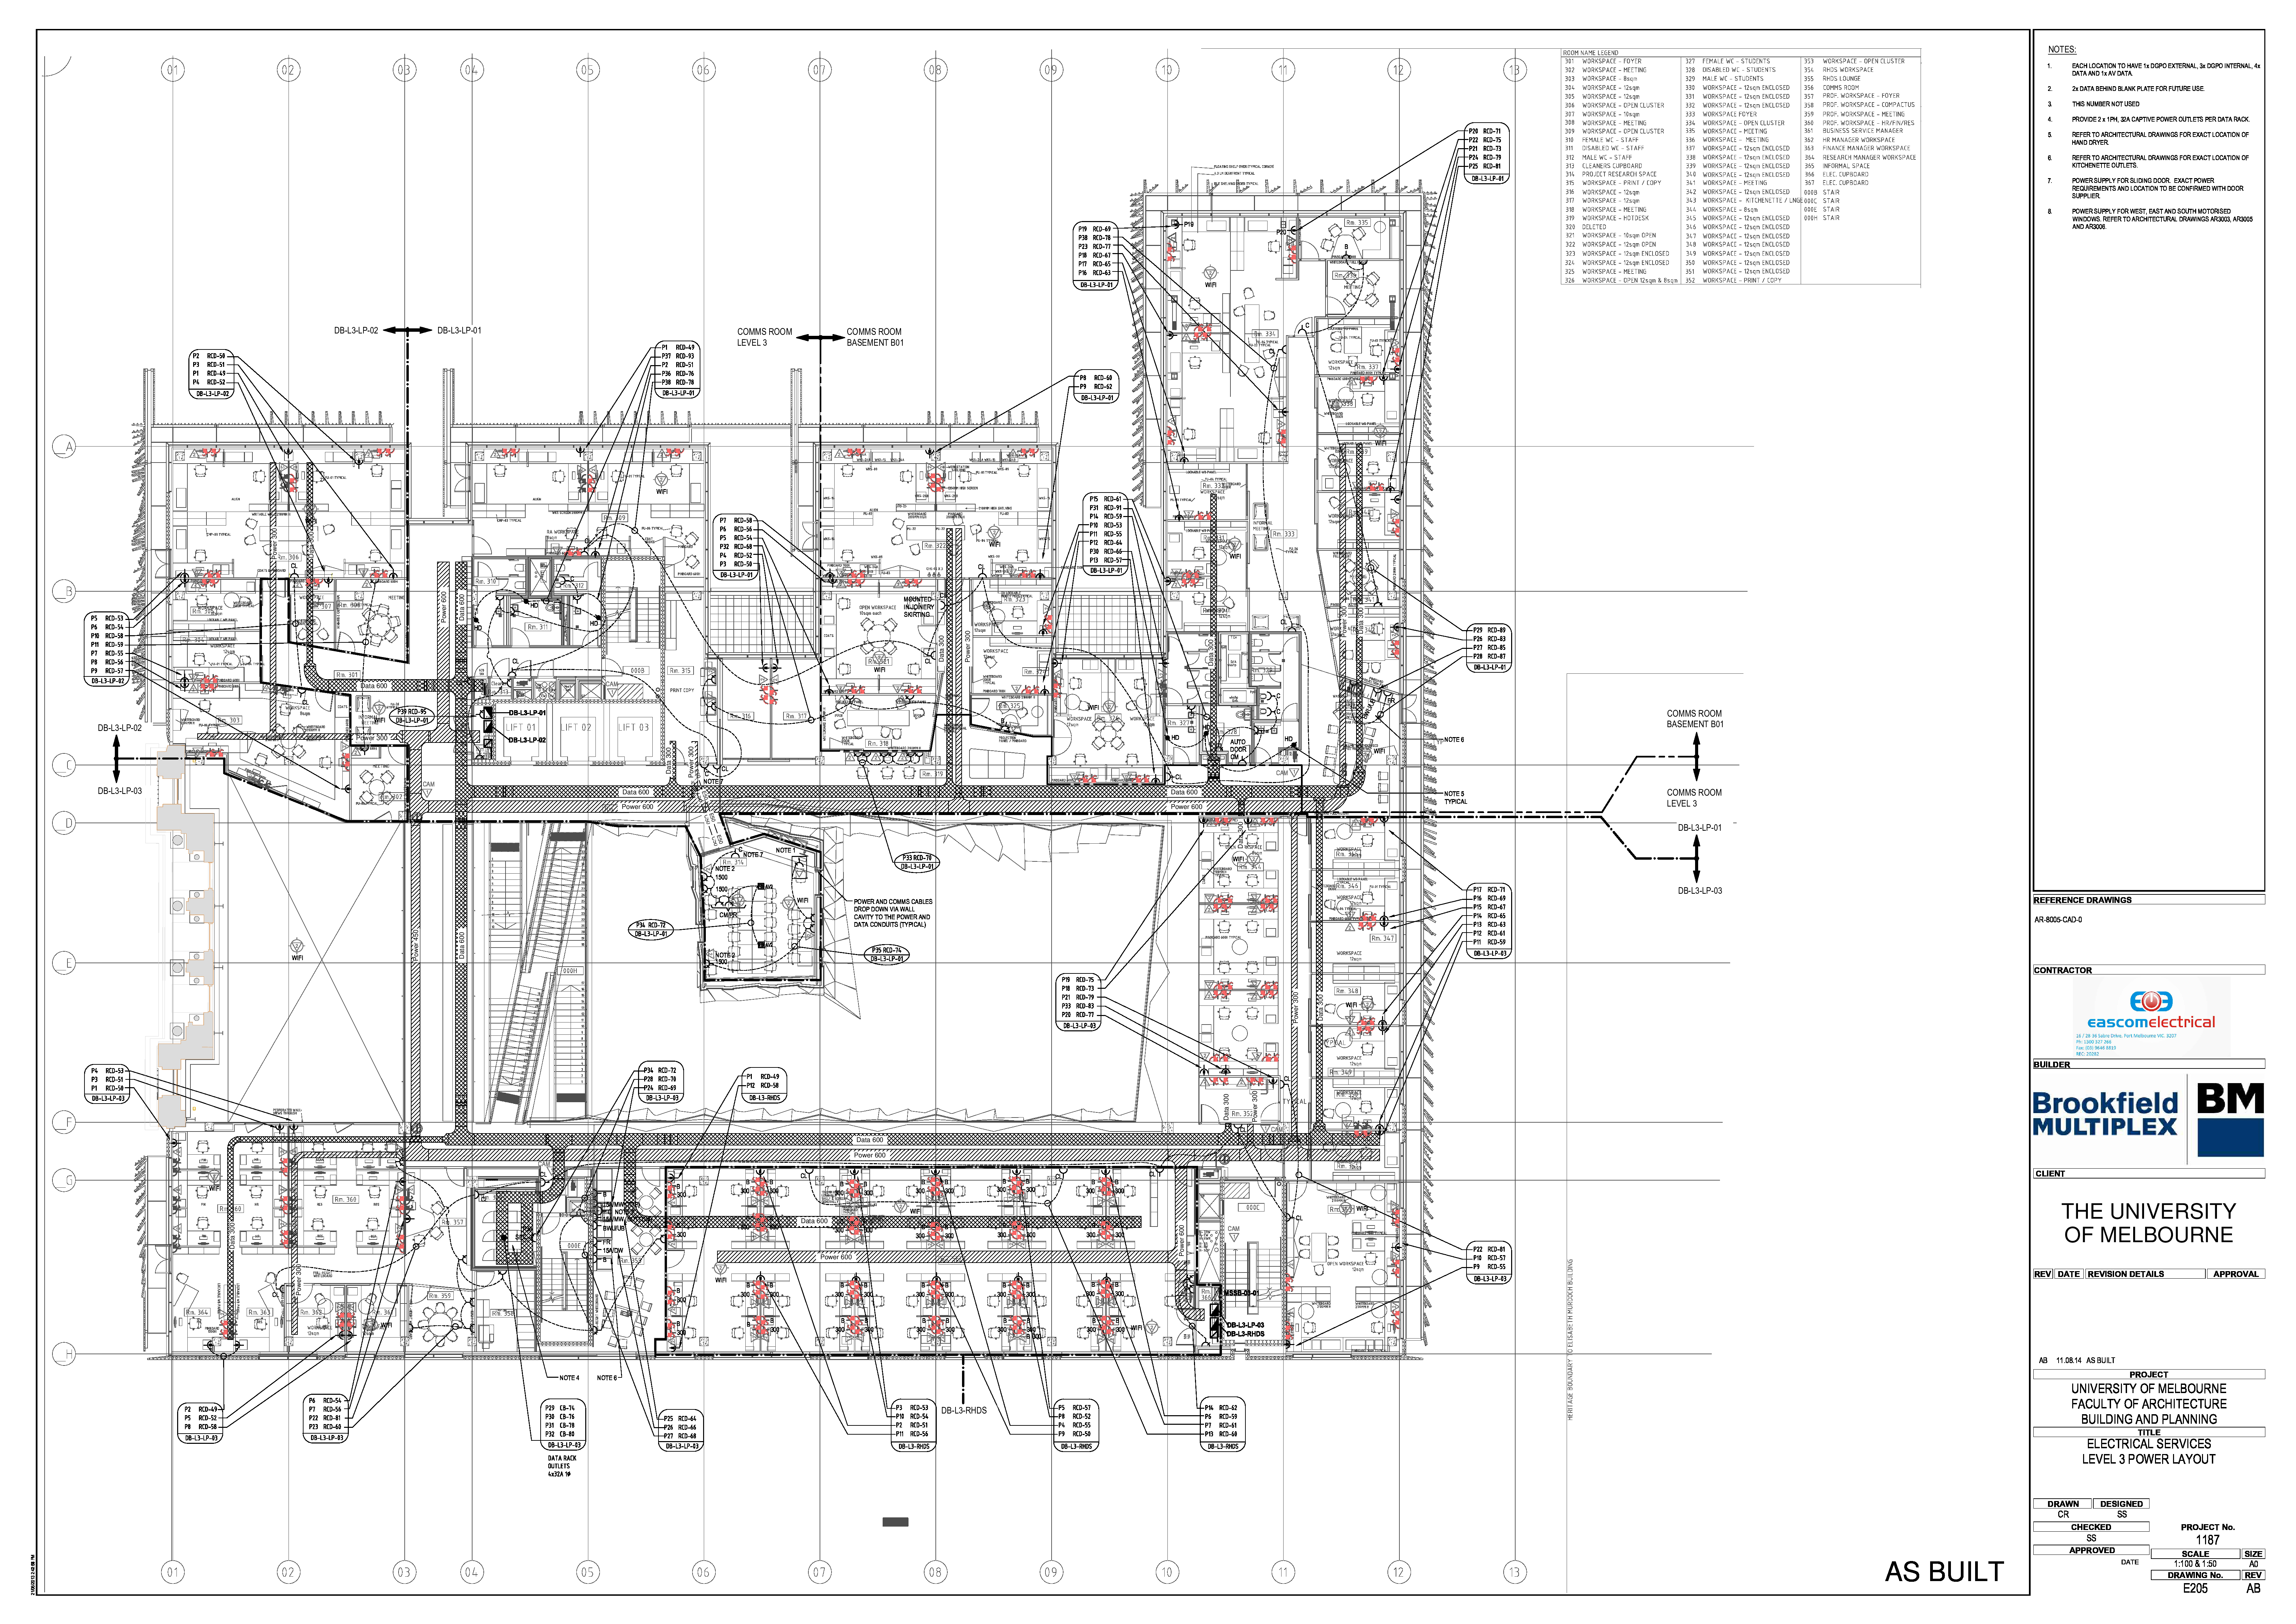

In [9]:
# Visualising the results of the matching function
im.reset()
for p in possibles:
    for x in range(p,p+9):
        im.draw_line(full.curves[x]["points"], stroke='#FF6666', stroke_width=2)
im